## Getting Started

Here is a reproduction of Predict if Tweets are about Real Disasters from PyDataGlobal 2021. Thanks for your contribution royn5618.

About the Dataset : Natural Language Processing with Disaster Tweets is a Kaggle Challenge where tweets are collected with labels indicating whether the tweets are about a disaster that occurred or not. Since tweets are social media language, therefore, it is a challenge to automatically identify them. Besides, ambiguity in texts makes it more difficult to achieve automatic identification of tweets containing information on real disaster. The objective of this project is to predict using machine learning if a tweet contains information on occurrence of a real disaster or not.

Source : https://www.kaggle.com/c/nlp-getting-started

In [3]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlepad'] = 30 

In [4]:
from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import contractions

In [5]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [7]:
df_train = pd.read_csv('/Users/pavla/Documents/Python/train.csv')

In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df_train.shape

(7613, 5)

In [10]:
for col in df_train.columns:
    print("{} has {} unique instances".format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


In [11]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Missing Values

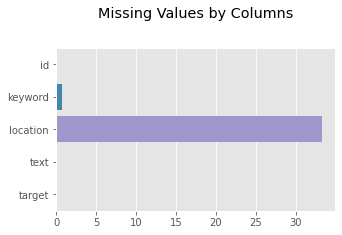

In [12]:
# Get the percentage of missing values
output = df_train.isnull().sum() * 100  / len(df_train) 
# type(output) : Pandas Series

# plot them
plt.figure(figsize=[5,3])
sns.barplot(y=list(output.index), x=list(output))
plt.title('Missing Values by Columns')
plt.show()

In [13]:
df_train[~df_train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [14]:
df_train[df_train['id'] == 48]['text']

31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
Name: text, dtype: object

### Column Names - STATIC

In [15]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
TEXT_TOKENIZED = 'Text Tokenized'
SENTIMENT = 'Sentiment Score'
SENTIMENT_ROUND = 'Sentiment Score (rounded off)'
WORDS_PER_TWEET = 'Words Per Tweet'
CHAR_PER_TWEET = 'Characters Per Tweet'
LOCATIONS = 'Locations'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'Number in Tweet'
PUNCTUATION_COUNT = 'Punctuation Count Per Tweet'
IDENTIFIABLE_LOCATION = 'Identifiable Location'
IN_BOW = 'Present In BOW'

## Keyword Analysis
* 1. Which keywords have occurred the most?
* 2. Which keywords have a higher percentage of tweets about real disasters?

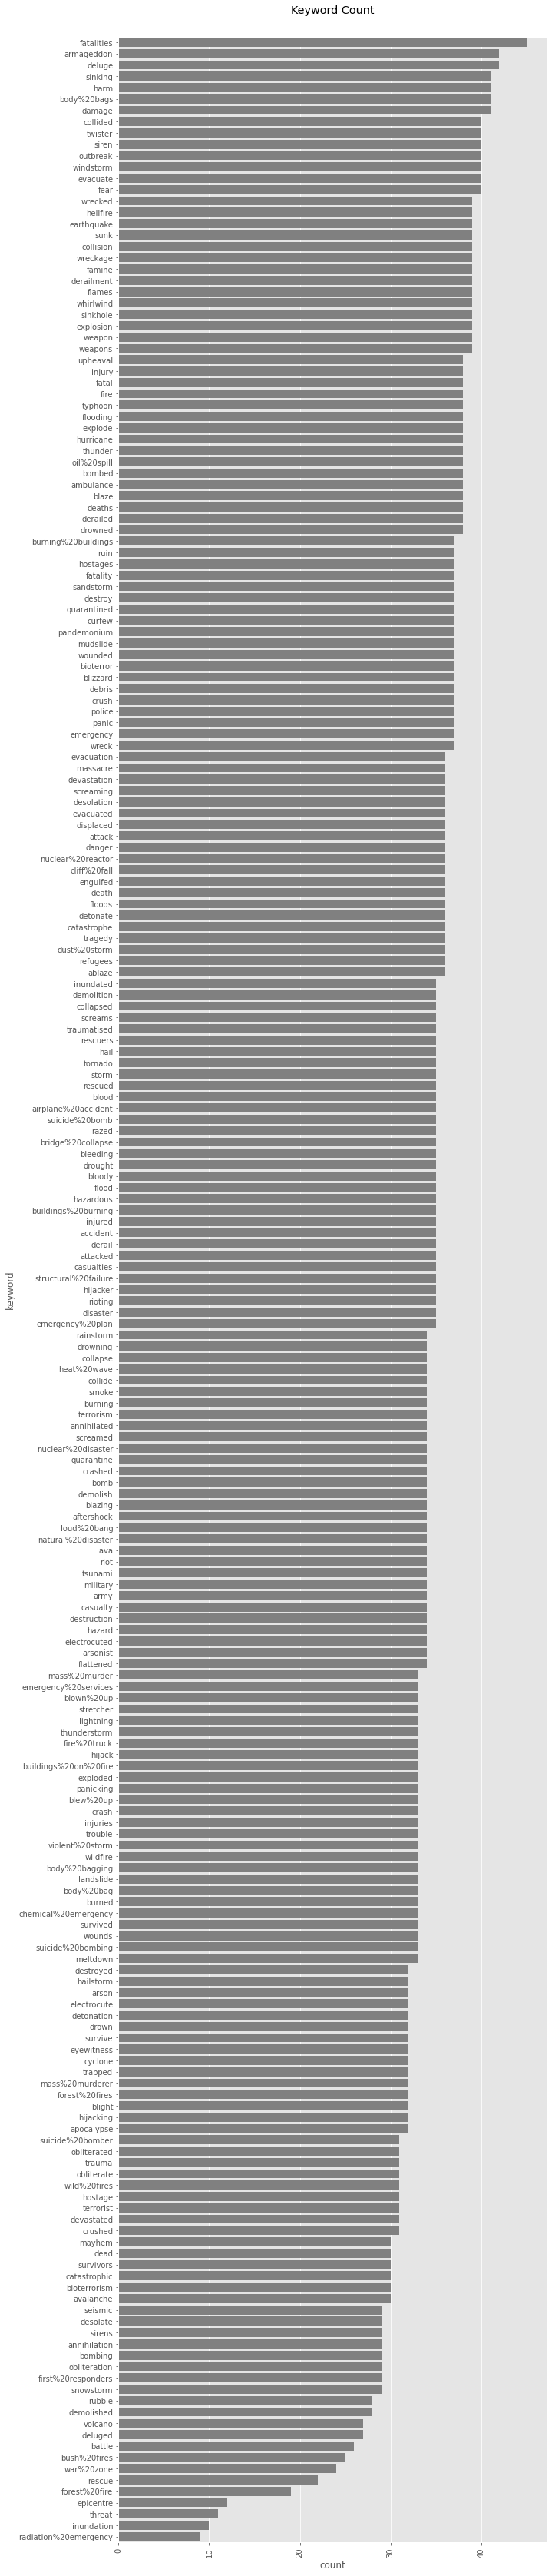

In [16]:
plt.figure(figsize=[10, 60])
sns.countplot(y=KEYWORD,
              data=df_train,
              palette=['grey'],
              order=df_train[KEYWORD].value_counts().index)
plt.xticks(rotation=90)
plt.title("Keyword Count")
plt.show()

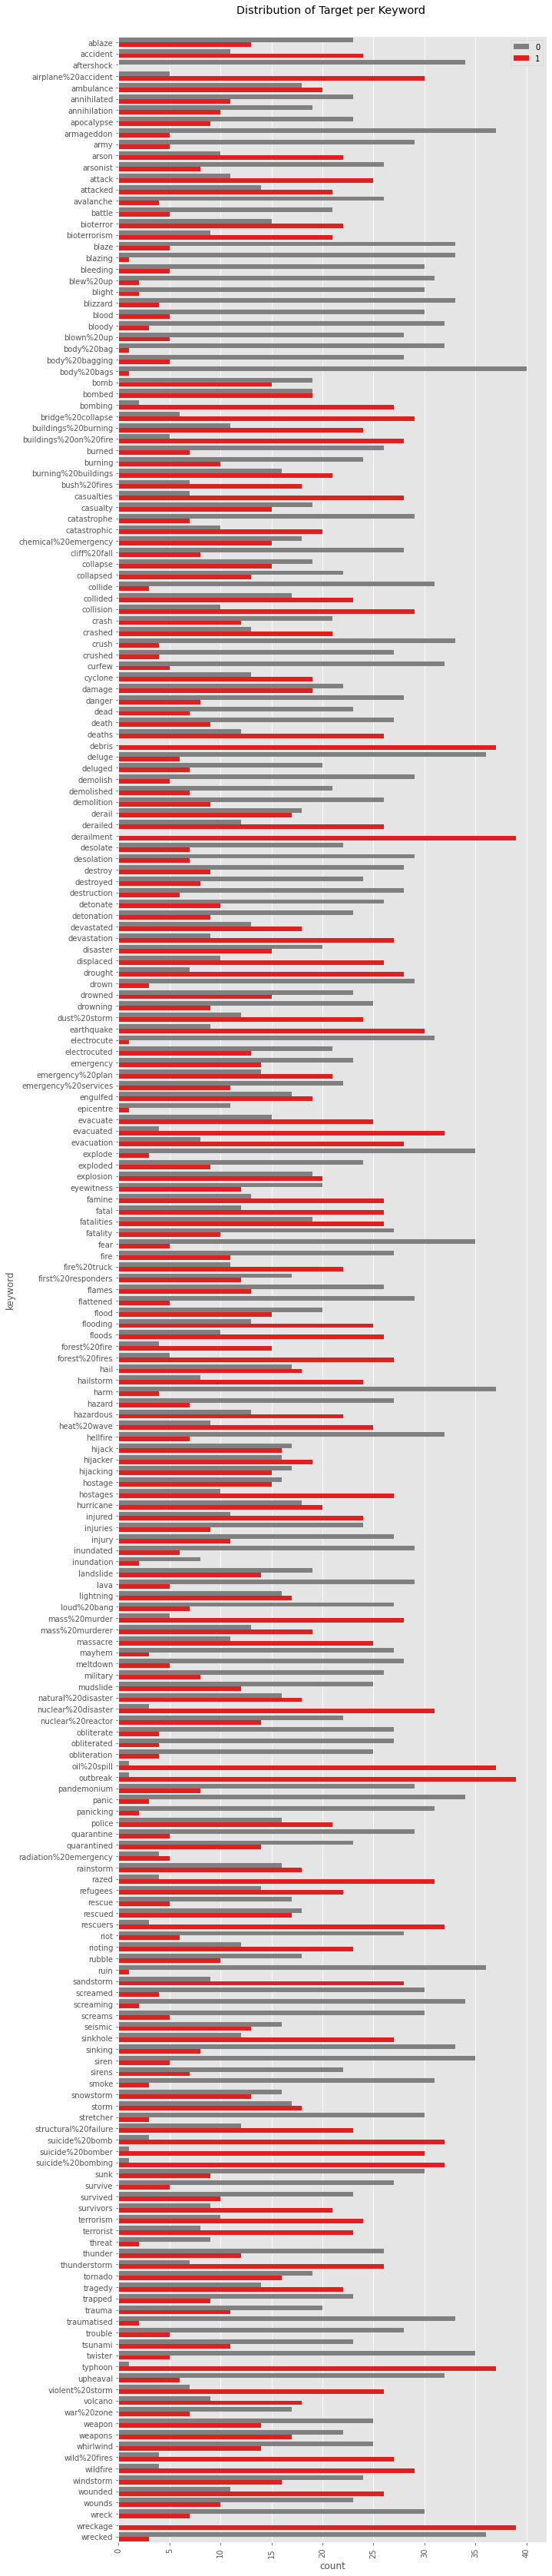

In [17]:
plt.figure(figsize=[10, 60])
sns.countplot(y=KEYWORD, hue=TARGET, data=df_train, palette=['grey', 'red'])
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title("Distribution of Target per Keyword ")
plt.show()

In [18]:
df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['@FoxNews @JenGriffinFNC When you call to report dangerous activity tell em to have body bags on arrival.'],
      dtype=object)

In [19]:
# Get keyword counts for tweets about real disasters
real_disaster_keywords = df_train[df_train['target'] == 1].groupby(['keyword', 'target']).count()['id'].reset_index()
real_disaster_keywords.head()

,keyword,target,id
0,ablaze,1,13
1,accident,1,24
2,airplane%20accident,1,30
3,ambulance,1,20
4,annihilated,1,11


In [20]:
# Get keyword counts for tweets not about real disasters
unreal_disaster_keywords = df_train[df_train['target'] == 0].groupby(['keyword', 'target']).count()['id'].reset_index()
unreal_disaster_keywords.head()

,keyword,target,id
0,ablaze,0,23
1,accident,0,11
2,aftershock,0,34
3,airplane%20accident,0,5
4,ambulance,0,18


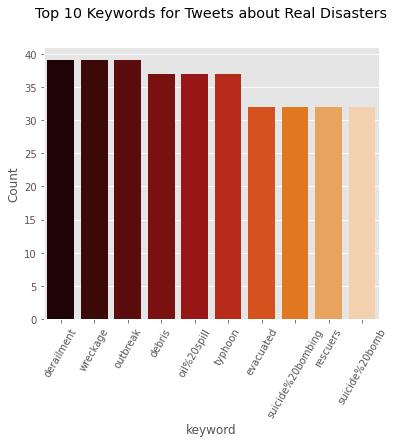

In [21]:
plt.figure(figsize=[6, 5])
sns.barplot(x=KEYWORD, y=ID, data=real_disaster_keywords.sort_values('id', ascending=False)[:10], palette='gist_heat')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Top 10 Keywords for Tweets about Real Disasters')
plt.show()

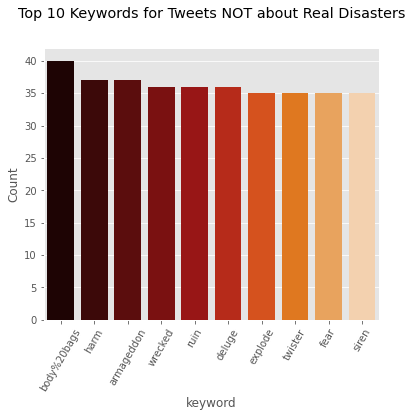

In [22]:
plt.figure(figsize=[6, 5])
sns.barplot(x=KEYWORD, y=ID, data=unreal_disaster_keywords.sort_values('id', ascending=False)[:10], palette='gist_heat')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Top 10 Keywords for Tweets NOT about Real Disasters')
plt.show()

In [23]:
merged_counts_keywords = pd.merge(
    left=real_disaster_keywords,
    right=unreal_disaster_keywords,
    left_on=KEYWORD,
    right_on=KEYWORD,
    how='outer').drop(columns=['target_x', 'target_y']).fillna(0)

merged_counts_keywords['prob_real_disasters'] = (
    merged_counts_keywords['id_x'] -
    merged_counts_keywords['id_y']) / merged_counts_keywords['id_x']

top_prob_real_disaster_keywords = merged_counts_keywords.sort_values(
    'prob_real_disasters', ascending=False)[:5]
top_prob_real_disaster_keywords

,keyword,id_x,id_y,prob_real_disasters
69,derailment,39.0,0.0,1.000000
61,debris,37.0,0.0,1.000000
218,wreckage,39.0,0.0,1.000000
152,outbreak,39.0,1.0,0.974359
204,typhoon,37.0,1.0,0.972973


## Target Analysis

In [24]:
df_train.target.value_counts() / len(df_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

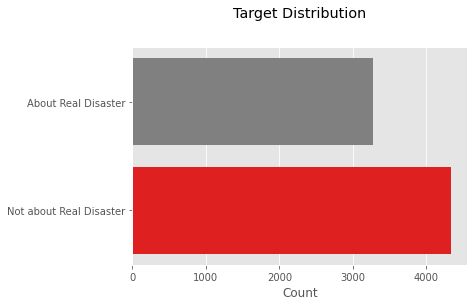

In [25]:
sns.countplot(y=TARGET,
              data=df_train[TARGET].replace({
                  0: 'Not about Real Disaster',
                  1: 'About Real Disaster'
              }).reset_index(),
              palette=['grey', 'red'])
plt.title('Target Distribution')
plt.ylabel(None)
plt.xlabel('Count')
plt.show()

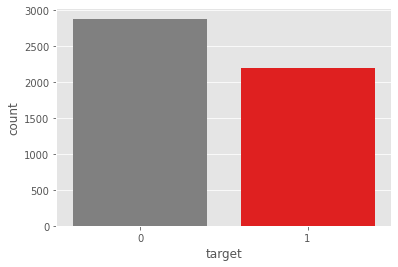

In [26]:
sns.countplot(x=TARGET, data=df_train[~df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

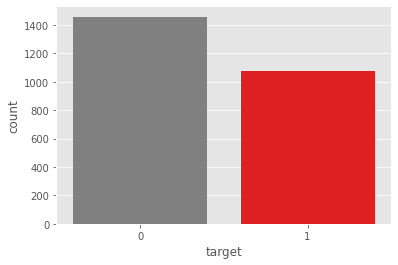

In [27]:
sns.countplot(x=TARGET, data=df_train[df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

## Top 20 locations
Some locations are more prone to real disasters and it is highly likely that tweets from those locations will be about real disasters.

In [28]:
df_train[df_train[TARGET] == 1].groupby(LOCATION)[TARGET].count().reset_index()

,location,target
0,,1
1,News,1
2,"616 Û¢ Kentwood , MI",1
3,? ??????? ? ( ?? å¡ ? ? ? å¡),1
4,Alberta,1
...,...,...
1508,"ÌÏT: 40.562796,-75.488849",1
1509,"ÌÏT: 41.252426,-96.072013",1
1510,"ÌÏT: 6.4682,3.18287",1
1511,"ÌÏT: 6.488400524109015,3.352798039832285",1


In [29]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET)

,location,target
0,,1
979,Porthcawl,1
978,"Portage, IN / Worldwide",1
977,Port Williams NS,1
976,"Port Orange, FL",1
...,...,...
787,Mumbai,19
576,India,20
857,Nigeria,22
1258,United States,27


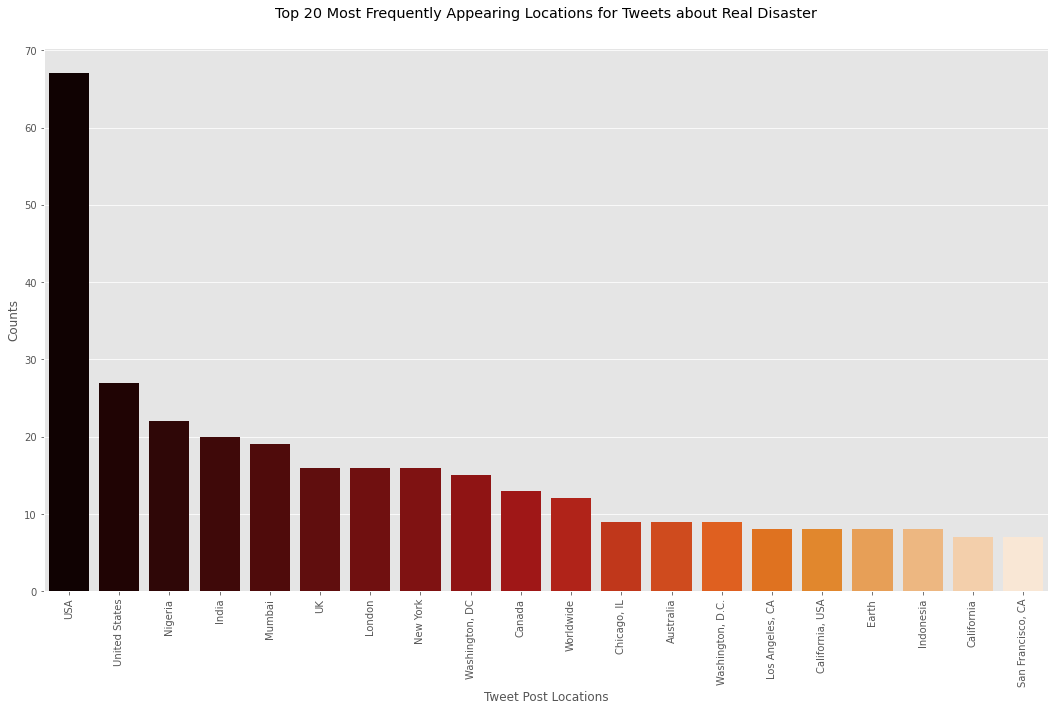

In [30]:
plt.figure(figsize=[18, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET,
                                                       ascending=False)[:20],
            palette='gist_heat'
           )
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequently Appearing Locations for Tweets about Real Disaster')
plt.xlabel('Tweet Post Locations')
plt.ylabel('Counts')
plt.show()

## Text Data Check

In [31]:
df_train[TEXT][800], df_train[TARGET][800]

("If you dotish to blight your car go right ahead. Once it's not mine.", 0)

## Basic Cleaning

In [32]:
test_string = 'I am at https://www.nabanita.org www.nabanita.org okay'
url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
test_op = re.sub(url_pattern, '', test_string)
test_op

'I am at   okay'

In [33]:
test_string = 'I am at <p>www.nabanita.org &nbsp;</p>'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org '

In [34]:
test_string = 'I am at @nabanita #python testing 123'
html_entities = r'@([a-z0-9]+)|#'
test_op = re.sub(html_entities, '', test_string)
test_op


'I am at  python testing 123'

## Text Preprocessing Functions

In [35]:
import contractions

def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text


def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text


def convert_lower_case(text):
    return text.lower()


def detect_news(text):
    '''Appends news to the end of the tweet if news appears anywhere in the tweet. 
    This is to avoid missing out on the keyword 'news' if it occured in a mention, for ex: @SomeNewsChannel'''
    if 'news' in text:
        text = text + ' news'
    return text


def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text


# Count it before I remove them altogether
def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', text)
    return len(getpunctuation)


def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        wnl.lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)

In [36]:
df_train[TEXT] = df_train[TEXT].apply(remove_urls)
df_train[TEXT] = df_train[TEXT].apply(remove_html_entities)
df_train[TEXT] = df_train[TEXT].apply(convert_lower_case)
df_train[TEXT] = df_train[TEXT].apply(detect_news)
df_train[TEXT] = df_train[TEXT].apply(remove_social_media_tags)
df_train[PUNCTUATION_COUNT] = df_train[TEXT].apply(count_punctuations)
df_train[TEXT] = df_train[TEXT].apply(preprocess_text)

In [37]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0


In [38]:
# Test

# Expected to remove @FoxNews but have ' news' in the tweet text

df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['call report dangerous activity tell body bag arrival news'],
      dtype=object)

## Punctuation Analysis

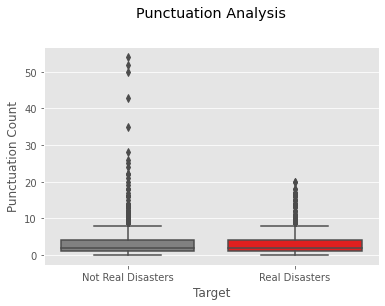

In [39]:
sns.boxplot(x=TARGET,
            y=PUNCTUATION_COUNT,
            data=df_train,
            palette=['grey', 'red'])
plt.title('Punctuation Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Punctuation Count')
plt.show()

## Keyword Check

In [40]:
def clean_keyword(text):
    if text is not np.nan and text:
        text = text.replace('%20', ' ')
    return text

In [41]:
df_train[KEYWORD] = df_train[KEYWORD].apply(clean_keyword)

In [42]:
df_train[KEYWORD] = df_train[KEYWORD].apply(clean_keyword)

## Mention of Numbers in Tweets

In [43]:
def get_numbers_in_tweet(text):
    list_numbers = re.findall(r'\d+', text)
    if list_numbers:
        return 1
    return 0

In [44]:
df_train[NUM_IN_TWEETS] = df_train[TEXT].apply(get_numbers_in_tweet)

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           7613 non-null   int64 
 1   keyword                      7552 non-null   object
 2   location                     5080 non-null   object
 3   text                         7613 non-null   object
 4   target                       7613 non-null   int64 
 5   Punctuation Count Per Tweet  7613 non-null   int64 
 6   Number in Tweet              7613 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 416.5+ KB


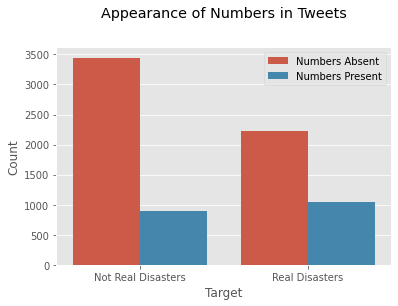

In [46]:
sns.countplot(x=TARGET, hue=NUM_IN_TWEETS, data=df_train)
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks = [0, 1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Appearance of Numbers in Tweets')
plt.legend(labels=['Numbers Absent', 'Numbers Present'])
plt.show()

## Sentiment Analysis


In [49]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [55]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [56]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [57]:
df_train[SENTIMENT] = df_train[TEXT].apply(lambda x: nlp(x)._.polarity)

In [58]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0,0,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,0,0.1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3,0,-0.1
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0


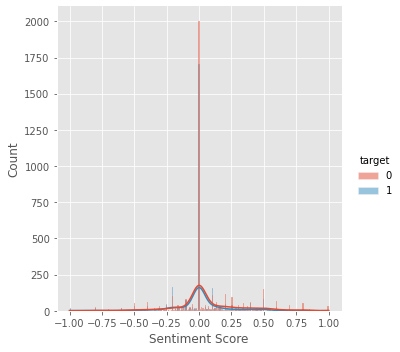

In [59]:
sns.displot(x=SENTIMENT, hue=TARGET, data=df_train, kde=True)
plt.show()

In [60]:
def sentiment_to_binary(x):
    if x > 0:
        return 1
    else:
        return 0

In [61]:
df_train[SENTIMENT_ROUND] = df_train[SENTIMENT].apply(sentiment_to_binary)
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off)
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0,0,0.0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,0,0.1,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3,0,-0.1,0
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1,1,0.0,0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0


In [62]:
df_train[SENTIMENT_ROUND].value_counts()

0    5278
1    2335
Name: Sentiment Score (rounded off), dtype: int64

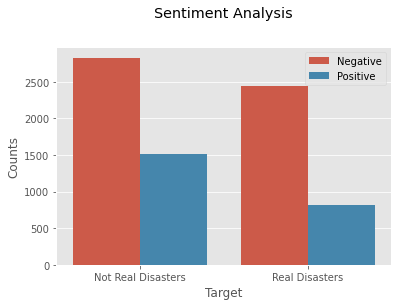

In [63]:
sns.countplot(x=TARGET, hue=SENTIMENT_ROUND, data=df_train)
plt.title('Sentiment Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Counts')
# plt.ylabel('Punctuation Count')
plt.legend(labels=['Negative', 'Positive'])
plt.show()

## Tweet Length Analysis


In [67]:
df_train[TEXT_TOKENIZED] = df_train[TEXT].apply(word_tokenize)

In [68]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Text Tokenized
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0,0,0.0,0,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,0,0.1,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3,0,-0.1,0,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1,1,0.0,0,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [69]:
df_train[WORDS_PER_TWEET] = df_train[TEXT_TOKENIZED].apply(len)
df_train[CHAR_PER_TWEET] = df_train[TEXT].apply(len)

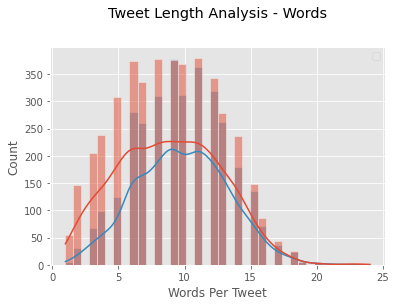

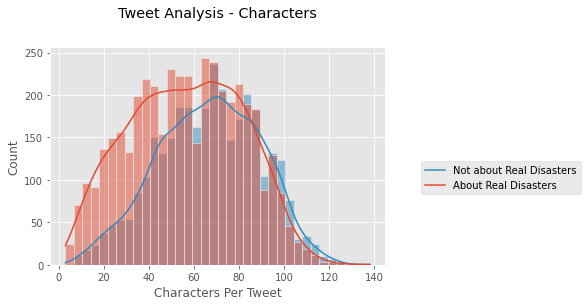

In [70]:
sns.histplot(x=WORDS_PER_TWEET, hue=TARGET, data=df_train, kde=True)
plt.title('Tweet Length Analysis - Words')
plt.legend([])
plt.show()
sns.histplot(x=CHAR_PER_TWEET, hue=TARGET, data=df_train, kde=True)
plt.title('Tweet Analysis - Characters')
plt.legend(labels=['Not about Real Disasters', 'About Real Disasters'], loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

## Tweet Text Analysis using WordCloud

In [72]:
real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 1][TEXT]))

In [73]:
non_real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 0][TEXT]))

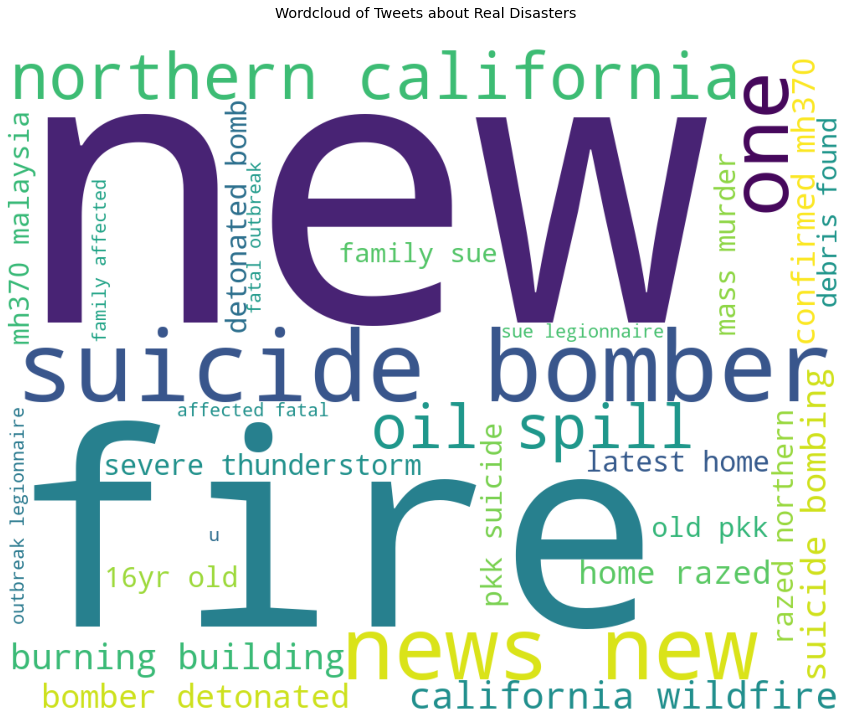

In [83]:
wc = WordCloud(background_color="white", 
               max_words=30, 
               width=1000, 
               height=800,
               collocation_threshold = 10,#this changes if one word, bigram or trigram are taken into account
               random_state=1).generate(real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets about Real Disasters")
plt.show()

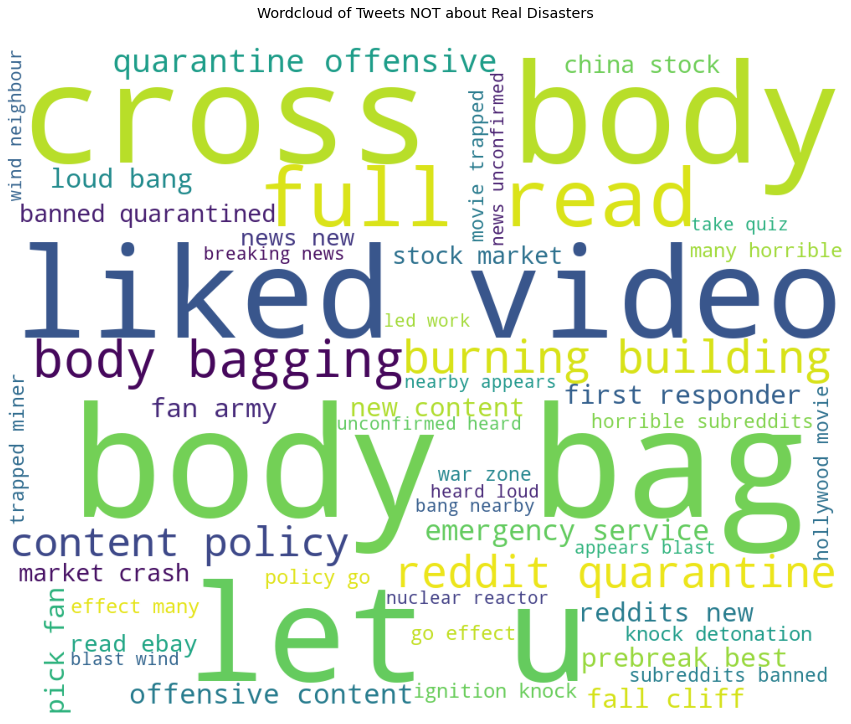

In [85]:
wc = WordCloud(background_color="white", 
               max_words=50, 
               width=1000, 
               height=800,
               collocation_threshold = 3,#this changes if one word, bigram or trigram are taken into account
               font_step=1,
               random_state=1).generate(non_real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets NOT about Real Disasters")
plt.show()

## Location Analysis

In [86]:
def check_location(x):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    spacy_loc = nlp(x)
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return [], 0
    return locs_in_tweet, 1

df_train[LOCATION].fillna('', inplace=True)
df_train[LOCATIONS], df_train[IDENTIFIABLE_LOCATION] = zip(*df_train[LOCATION].apply(check_location))

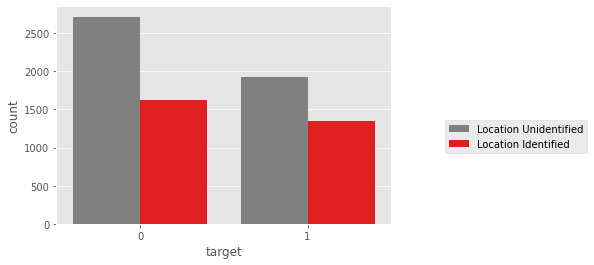

In [87]:
sns.countplot(x=TARGET, hue=IDENTIFIABLE_LOCATION, data=df_train, palette=['grey', 'red'])
plt.legend(labels=['Location Unidentified', 'Location Identified'], loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

## Final Text Data Preparation

In [88]:
df_train[ALL_TEXT] = df_train[TEXT_TOKENIZED] + df_train[LOCATIONS]
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Text Tokenized,Words Per Tweet,Characters Per Tweet,Locations,Identifiable Location,all_text
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,0.0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,[],0,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,0.1,1,"[forest, fire, near, la, ronge, sask, canada]",7,37,[],0,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,-0.1,0,"[resident, asked, shelter, place, notified, of...",11,85,[],0,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,0.0,0,"[13000, people, receive, wildfire, evacuation,...",7,57,[],0,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,[],0,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [89]:
target = df_train[TARGET].values

In [90]:
df_train[ALL_TEXT_JOINED] = df_train[ALL_TEXT].apply(lambda x: " ".join(x))

## Building a Data Modeling Pipeline

### Helper Functions

In [91]:
def print_classification_metrics(y_train, train_pred, y_test, test_pred):
    print('Training Accuracy: ', accuracy_score(y_train, train_pred))
    print('Training f1-score: ', f1_score(y_train, train_pred))
    print('Accuracy: ', accuracy_score(y_test, test_pred))
    print('Precision: ', precision_score(y_test, test_pred))
    print('Recall: ', recall_score(y_test, test_pred))
    print('f1-score: ', f1_score(y_test, test_pred))


### Count Vectorizer

In [92]:
cols_to_train = [ALL_TEXT_JOINED]

# using this tokenizing strategy.
# You could use the normal tokenizer in this case
# using the Tweet tokenizer just for demo - in case you might use the text directly without prepping
# in that case you can set lower_case, strip_accents, stop_words when you call CountVectorizer()
# Refer here -https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
tt = TweetTokenizer()


# Splitting the data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('count_vec',
                         CountVectorizer(tokenizer=tt.tokenize,
                                         ngram_range=(1, 2)),
                                         ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

In [93]:
X_train_sparse.shape

(6090, 53713)

In [94]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse) # data is unseen by the model
training_prediction = log_reg.predict(X_train_sparse) # data is seen by the model

In [95]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.987192118226601
Training f1-score:  0.9850057670126874
Accuracy:  0.8069599474720945
Precision:  0.8244972577696527
Recall:  0.6949152542372882
f1-score:  0.754180602006689


## TF-IDF Vectorizer

In [96]:
cols_to_train = [ALL_TEXT_JOINED]

tt = TweetTokenizer()

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('tfidf',
                         TfidfVectorizer(tokenizer=tt.tokenize,
                                         ngram_range=(1, 2),
                                         smooth_idf=True), ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

In [97]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [98]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.9116584564860427
Training f1-score:  0.8880565959217644
Accuracy:  0.8017071569271176
Precision:  0.8242990654205608
Recall:  0.6795069337442219
f1-score:  0.7449324324324325
